# Preparation

### Import and constants

In [1]:
import numpy as np
from numpy.random import seed
seed(12345)

import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, Reshape
from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from google.colab import drive
from google.colab.patches import cv2_imshow

In [2]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [3]:
#get name of image with index
def file_name(image_num):
  return "image{}.jpg".format(image_num)

#get full path of image with index
def file_path(image_num):
  folder = 'drive/MyDrive/Colab Notebooks/StreetCamera_XX'
  return os.path.join(folder,file_name(image_num))

In [39]:
def show_results(history):
  # Show training history (this cell is complete, nothing to implement here :-) )
  h = history.history
  epochs = range(len(h['loss']))

  plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
  plt.legend(['Train', 'Validation'])
  plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                            epochs, h['val_accuracy'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

  print('Train Acc     ', h['accuracy'][-1])
  print('Validation Acc', h['val_accuracy'][-1])

###Data preparation


In [5]:
# Load data from the folder
train_dataset = []
test_dataset = []
for image_num in range(0,21553,10): #we will take not all data for the first time
  img = cv2.imread(file_path(image_num))
  if img is not None:
    train_dataset.append(img)

for image_num in range(1,21554,50): #this way be another data
  img = cv2.imread(file_path(image_num))
  if img is not None:
    test_dataset.append(img)

train_dataset = np.array(train_dataset)
test_dataset = np.array(test_dataset)

In [6]:
hight = train_dataset.shape[1]
width = train_dataset.shape[2]

### Data inspaction

In [7]:
print('Train set:   ', len(train_dataset), 'samples')
print('Test set:    ', len(test_dataset), 'samples')
print('Sample dims: ', train_dataset.shape)

Train set:    2156 samples
Test set:     432 samples
Sample dims:  (2156, 108, 192, 3)


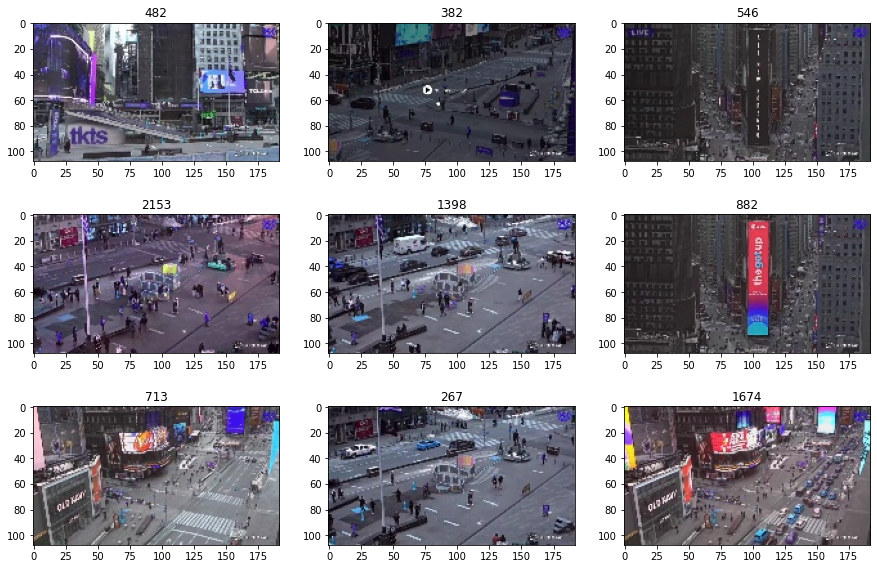

In [8]:
# Show random samples
for ii in range(9):
    image_num = np.random.randint(0, len(train_dataset))
    plt.subplot(3,3,ii+1), plt.imshow(train_dataset[image_num, ...])
    plt.title(str(image_num))

#Building model

In [9]:
# Normalization

train_dataset = train_dataset.astype('float32')/255
#for ii in range(len(train_dataset)):
#  train_dataset[ii, ...] = train_dataset[ii, ...]/255

test_dataset = test_dataset.astype('float32')/255

## Simple model (etalon)

In [25]:
latent_dim = 100 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      Flatten(),
      Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      Dense(width*hight*3, activation='sigmoid'),
      Reshape((hight, width, 3))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [37]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=["accuracy"])

In [38]:
epochs = 10
batch_size = 32
history = autoencoder.fit(train_dataset, train_dataset,
                epochs=epochs,
                shuffle=True,
                validation_data=(test_dataset, test_dataset))

Epoch 1/10
68/68 [==============================] - 15s 213ms/step - loss: 0.0090 - accuracy: 0.7821 - val_loss: 0.0077 - val_accuracy: 0.8032
Epoch 2/10
68/68 [==============================] - 15s 220ms/step - loss: 0.0079 - accuracy: 0.7975 - val_loss: 0.0077 - val_accuracy: 0.7981
Epoch 3/10
68/68 [==============================] - 17s 249ms/step - loss: 0.0080 - accuracy: 0.7940 - val_loss: 0.0077 - val_accuracy: 0.7927
Epoch 4/10
68/68 [==============================] - 14s 205ms/step - loss: 0.0079 - accuracy: 0.7913 - val_loss: 0.0078 - val_accuracy: 0.7907
Epoch 5/10
68/68 [==============================] - 14s 204ms/step - loss: 0.0079 - accuracy: 0.7952 - val_loss: 0.0077 - val_accuracy: 0.7921
Epoch 6/10
68/68 [==============================] - 20s 290ms/step - loss: 0.0084 - accuracy: 0.7830 - val_loss: 0.0089 - val_accuracy: 0.7847
Epoch 7/10
68/68 [==============================] - 14s 204ms/step - loss: 0.0081 - accuracy: 0.7930 - val_loss: 0.0078 - val_accuracy: 0.7951

Train Acc      0.7927541136741638
Validation Acc 0.8017545938491821


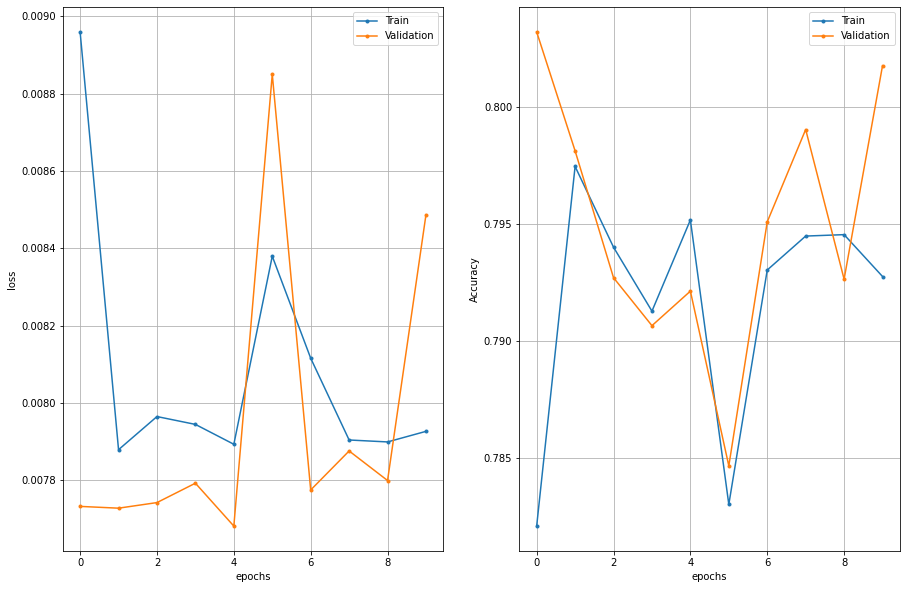

In [40]:
show_results(history)